In [ ]:
# This notebook is used to analyze potential snoRNA-rRNA interactions
# Steps:
# build full legngth rDNA index (seq from https://www.ncbi.nlm.nih.gov/nuccore/KY962518)
# map to full length rRNA index and get chimeric reads containing snoRNA.

In [5]:
import os
from glob import glob
from tqdm.auto import tqdm, trange
import pybedtools
import pandas as pd
import numpy as np
import coolbox
from coolbox.api import *
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO
plt.rcParams['figure.dpi'] = 100
fastp = '/tools/bin/fastp'
STAR = '/tools/bin/STAR'
samtools = '/tools/bin/samtools'
bedtools = '/tools/bin/bedtools'
bedGraphToBigWig = '/tools/bin/bedGraphToBigWig'

In [ ]:
def get_snoRNA_rDNA_paired_txt(bed_output):
    '''
    process chimeric bed files, convert it to a dataframe containing pair information
    '''
    df = pybedtools.BedTool(f'{bed_output}').to_dataframe()
    df = df.sort_values(by = ['name', 'chrom'])
    df = df[df.duplicated('name', keep=False)]
    df_2 = pd.concat([df[::2].reset_index(drop = True), df[1::2].reset_index(drop = True)], axis=1)
    df_2.columns = ['chr1', 'start1', 'end1', 'qname1', 'score1', 'strand1', 
                    'chr2', 'start2', 'end2', 'qname2', 'score2', 'strand2']
    dummy = np.sum(df_2['qname1']!=df_2['qname2'])
    print(f'sanity check:{dummy}')

    df_2 = df_2[(df_2['strand2']=='-')]
    df_2 = df_2[(df_2['chr1']!='KY962518.1')|(df_2['chr2']!='KY962518.1')]
    df_2 = df_2[~((df_2['chr1']!='KY962518.1')&(df_2['chr2']!='KY962518.1'))]
    df_2 = df_2[df_2['end2']-df_2['start2']<=300]
    df_2 = df_2[df_2['end1']-df_2['start1']<=300]
    return df_2

def get_bw_files(bedfile_df, output_path, name, sizes='rDNA.sizes', scale = 1):
    '''
    input path to bed file df, the output path, 
    names of the individual run (name), a sizes file, and a scale factor to output bw files
    '''
    df = bedfile_df.reset_index(drop=True)
    pair_bed6 = df[['chr1', 'start1', 'end1', 'qname1', 'chr2', 'strand1']]
    pair_bed6 = pybedtools.BedTool.from_dataframe(pair_bed6)
    pair_bed6.saveas(f'{output_path}/chim_{name}.bed')
    cmd0 = f'cat {output_path}/chim_{name}.bed\
    | sort -V -k1,1 -k2,2n -k3,3n > {output_path}/{name}_sorted.bed'
    os.system(cmd0)
    cmd1 = f'{bedtools} genomecov -bg -scale 1  \
    -i {output_path}/{name}_sorted.bed -g {sizes} \
    | LC_COLLATE=C sort -k1,1 -k2,2n > {output_path}/{name}_sorted.bedgraph'
    os.system(cmd1)

    cmd2 = f'{bedGraphToBigWig} {output_path}/{name}_sorted.bedgraph {sizes} \
    {output_path}/{name}_sorted.bw'
    os.system(cmd2)

def get_bam_len(path):
    '''
    count the length of a bam file given the path
    '''
    #cmd = f"{samtools} view -@ 40 {path} | wc -l"
    # using the Log.out.final file
    cmd = f"cat {path} | head -6 | tail -1 | awk \'{{print $NF}}\'"
    p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
    bam_len = int(p.communicate()[0])
    return bam_len

In [ ]:
# build star index for human rDNA
# using sequence from https://www.ncbi.nlm.nih.gov/nuccore/KY962518
os.system('/tools/bin/STAR --runMode genomeGenerate \
--runThreadN 40 \
--genomeDir /home/beiliu/Database/reference/human_rDNA/human_rDNA_STAR_index \
--genomeFastaFiles /home/beiliu/Database/reference/human_rDNA/human_rDNA.fa \
--genomeSAindexNbases 4')

In [ ]:
# build index for 190 snoRNA + rDNA
os.system('/tools/bin/STAR --runMode genomeGenerate \
--runThreadN 40 \
--genomeDir /home/beiliu/Database/reference/human_rDNA_snoRNA/human_rDNA_190snoRNA_STAR_index \
--genomeFastaFiles /home/beiliu/Database/reference/human_rDNA_snoRNA/rDNA_190_snoRNA_rRNA.fa \
--genomeSAindexNbases 4')

In [ ]:
# process raw data, using HepG2 data as an example
# fastp to remove primers and merge
sample_names = ['HepG2_totalRNA_input1', 'HepG2_totalRNA_input1' 
               'HepG2_totalRNA_IP1', 'HepG2_totalRNA_IP2']

# 'HepG2_totalRNA_input1', 'HepG2_totalRNA_input1'
gz_dir1 = 'HepG2_Input/'
gz_files1 = sorted(glob(os.path.join(gz_dir1, '*')))

# 'HepG2_totalRNA_IP1', 'HepG2_totalRNA_IP2'
gz_dir2 = 'HepG2_IP/'
gz_files2 = sorted(glob(os.path.join(gz_dir2, '*')))

gz_files_total = gz_files1 + gz_files2

# process raw reads using fastp

In [ ]:
input_prefix = '/home/beiliu/data/002_snoRNA_rRNA_promoter_interaction/HepG2_data'
trimed_dir = f'{input_prefix}/fastp_processed'
os.system(f'mkdir {trimed_dir}')
gz_file_lst = gz_files_total
gz_file_lst = gz_files_total_HEK293
gz_file_lst = gz_files_total_cancer
for i in trange(int(len(gz_file_lst)/2)):
    # merge and trim adapter
    input1 = gz_file_lst[i*2]
    input2 = gz_file_lst[i*2+1]
    print(f'inputs are\n 1.{input1}\n 2.{input2}\n')
    
    os.system(f'{fastp} --in1 {input1} \
    --in2 {input2} \
    -m \
    --out1 {trimed_dir}/unmerged_out1.fasta.gz \
    --out2 {trimed_dir}/unmerged_out2.fasta.gz \
    --merged_out {trimed_dir}/merged{i+1}.fasta.gz \
    -w 16 -D \
    -h {trimed_dir}/merge_and_trim_adapter_{i+1}.html \
    -j {trimed_dir}/merge_and_trim_adapter_{i+1}.json &')
    
    #dedupe and trim XXX
    os.system(f'nohup {fastp} -i {trimed_dir}/merged{i+1}.fasta.gz \
    -D -t 3 -w 16 \
    -o {trimed_dir}/merged{i+1}_dedupe.fasta.gz \
    -h {trimed_dir}/dedupe_and_trim_xxx_{i+1}.html \
    -j {trimed_dir}/dedupe_and_trim_xxx_{i+1}.json')
    
    os.system(f'rm {trimed_dir}/merged{i+1}.fasta.gz')
    
os.system(f'rm {trimed_dir}/unmerged*')

In [9]:
# prepare data for HepG2 and HEK293T 
input_prefix_HepG2 = 'HepG2_data'
output_foldername_HepG2 = f'{input_prefix_HepG2}/star_dedupe_alignment_rDNA'
sample_names_HepG2 = ['HepG2_totalRNA_input1', 'HepG2_totalRNA_input1',
               'HepG2_totalRNA_IP1', 'HepG2_totalRNA_IP2']
HepG2_series = [input_prefix_HepG2, output_foldername_HepG2, sample_names_HepG2]

input_prefix_HEK293 = 'HEK293_data'
output_foldername_HEK293 = f'{input_prefix_HEK293}/star_dedupe_alignment_rDNA'
sample_names_HEK293 = ['HEK293_totalRNA_input1', 'HEK293_totalRNA_input1',
               'HEK293_totalRNA_IP1', 'HEK293_totalRNA_IP2']
HEK293_series = [input_prefix_HEK293, output_foldername_HEK293, sample_names_HEK293]

# map to rDNA + snoRNA

In [ ]:
# map rDNA + snoRNA, using HepG2 data here as an example
gen_dir = 'human_rDNA_190snoRNA_STAR_index'
sample_names = HepG2_series[-1]
input_prefix = HepG2_series[0]

for i, name_prefix in tqdm(enumerate(sample_names), total = len(sample_names)):
    input1 = f'{trimed_dir}/merged{i+1}_dedupe.fasta.gz'
    print(f'STAR alignment input is {input1}')
    os.system(f'nohup {STAR} --runThreadN 10 \
    --runMode alignReads \
    --genomeDir {gen_dir} \
    --readFilesIn {input1}  \
    --outFileNamePrefix {input_prefix}/star_dedupe_alignment_rDNA/{i+1:03d}_{name_prefix} \
    --readFilesCommand zcat \
    --outFilterMultimapNmax 10 \
    --outFilterScoreMinOverLread 0 \
    --outFilterMatchNminOverLread 0 \
    --outSAMattributes All \
    --outSAMtype BAM SortedByCoordinate \
    --alignIntronMin 1 \
    --scoreGap 0 \
    --scoreGapNoncan 0 \
    --scoreGapGCAG 0 \
    --scoreGapATAC 0 \
    --scoreGenomicLengthLog2scale -1 \
    --chimFilter None \
    --chimOutType WithinBAM HardClip \
    --chimSegmentMin 5 \
    --chimJunctionOverhangMin 5 \
    --chimScoreJunctionNonGTAG 0 \
    --chimScoreDropMax 80 \
    --chimNonchimScoreDropMin 20 \
    --peOverlapNbasesMin 12 \
    --peOverlapMMp 0.05 \
    --limitOutSJcollapsed 10000000 \
    --limitBAMsortRAM 2007370404 &')

In [ ]:
# process bam file to get chimeric reads
output_all_HepG2 = []
output_all_HEK = []
output_all = [output_all_HepG2, output_all_HEK]

for j, (m, n, k) in enumerate([HepG2_series]):
    # if j!=0:
    #     continue
    # print(i, m, n, k)
    for i, name_prefix in tqdm(enumerate(k), total = len(k)):
        # get all chimeric reads and sort by qname
        bamfile = f'{n}/{i+1:03d}_{name_prefix}Aligned.sortedByCoord.out.bam'
        print(f'input bamfile is {bamfile}...')
        # 1. extract all chimeric reads
        cmd1 = f'nohup {samtools} view -@ 40 -Shb -e \"[SA]\" \
        {bamfile} | {samtools} sort -@ 40 -n -o {n}/{i+1:03d}_chimall.bam - &'
        os.system(cmd1)

        # 2. chimall bam to bed
        input_bam = f'{n}/{i+1:03d}_chimall.bam'
        print(f'chimall to bed {input_bam}...')
        bed_output = f'{n}/{i+1:03d}_chimall.bed'
        os.system(f'nohup {bedtools} bamtobed -i {input_bam} > {bed_output} &')

        # 3. get snoRNA rRNA bed output
        output_all[j].append(get_snoRNA_rDNA_paired_txt(bed_output))

In [ ]:
# generate bw files
os.system('mkdir bw_output')
for snoRNA in top_50_snoRNA_names.values:
    print(snoRNA)
    # now run bw files for all chim bed
    for j, (m, n, k) in enumerate([HepG2_series, HEK293_series]):
        # print(i, m, n, k)
        for i, name_prefix in tqdm(enumerate(k), total = len(k)):
            bamfile = f'{n}/{i+1:03d}_{name_prefix}Log.final.out'
            print(bamfile)
            scale = 1e6/get_bam_len(bamfile)
    
            bedfile_df = output_all[j][i]
            # snoRNA = 'SNORA6'
            bedfile_df = bedfile_df[bedfile_df['chr2']==snoRNA]
            bedfile_df = bedfile_df.drop_duplicates(['start1', 'end1', 'start2', 'end2'])
            print(f'length of selected df is {len(bedfile_df)}')
            get_bw_files(bedfile_df, 'bw_output', k[i]+f'_{snoRNA}', scale = scale)

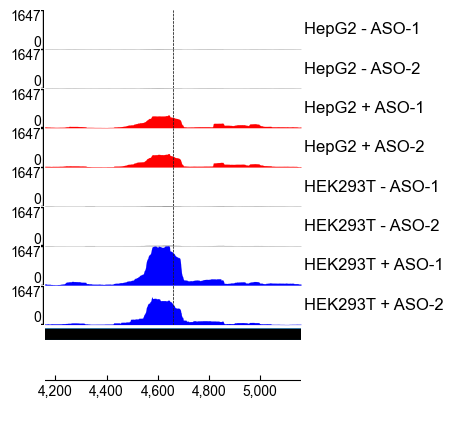

In [28]:
# now use coolbox to plot the coverage of the intron regions of snoRNA containing genes
snoRNA = 'SNORA57'
mod_site = 4659
bw_files_HepG2 = [f'bw_output/{name}_{snoRNA}_sorted.bw' for name in HepG2_series[-1]]
bw_files_HEK293 = [f'bw_output/{name}_{snoRNA}_sorted.bw' for name in HEK293_series[-1]]
tracknames_HepG2 = ['HepG2 - ASO-1', 'HepG2 - ASO-2', 'HepG2 + ASO-1', 'HepG2 + ASO-2']
tracknames_HEK293 = ['HEK293T - ASO-1', 'HEK293T - ASO-2', 'HEK293T + ASO-1', 'HEK293T + ASO-2']

# remove the old index file
os.system('rm /home/beiliu/Database/reference/human_rDNA_snoRNA/rDNA.bed.bgz.tbi')
frame1 = BigWig(bw_files_HepG2[0]) + Color("grey") + Title(f'{tracknames_HepG2[0]}') + \
BigWig(bw_files_HepG2[1]) + Color("grey") + Title(f'{tracknames_HepG2[1]}') + \
BigWig(bw_files_HepG2[2]) + Color("red") + Title(f'{tracknames_HepG2[2]}') + \
BigWig(bw_files_HepG2[3]) + Color("red") + Title(f'{tracknames_HepG2[3]}') + \
BigWig(bw_files_HEK293[0]) + Color("grey") + Title(f'{tracknames_HEK293[0]}') + \
BigWig(bw_files_HEK293[1]) + Color("grey") + Title(f'{tracknames_HEK293[1]}') + \
BigWig(bw_files_HEK293[2]) + Color("blue") + Title(f'{tracknames_HEK293[2]}') + \
BigWig(bw_files_HEK293[3]) + Color("blue") + Title(f'{tracknames_HEK293[3]}')
frame1*=TrackHeight(1)

coord = f'KY962518.1:.{mod_site-500}-{mod_site+500}' # SNORA57 rRNA binding site
frame1.plot(coord)

#get the maximun y value, and generate y_lim
data_dict = frame1.fetch_plot_data()
new_dict = {key:val for key, val in data_dict.items() if 'Spacer' not in key}
max_y = np.max([np.max(data_dict[list(new_dict.keys())[i]]) for i in range(8)])
y_lim = np.ceil(max_y)
frame1*=MaxValue(int(max_y))
frame1*=MinValue(0)
# highlight the modification site
frame1*=Vlines(('KY962518.1', mod_site), line_width = 0.5)

frame1 += Spacer(0.1) + BED(f"/home/beiliu/Database/reference/human_rDNA_snoRNA/rDNA.bed", display='stacked', interval_height=1, fontsize=10, color = 'k') + TrackHeight(0.3) + XAxis(fontsize=10)
frame1.properties['width'] = 8
frame1.plot(coord)